# A predictive approach to estimate the maximum voluntary activation of the shoulder muscles

Romain Martinez<sup>*a</sup>, Jonathan Tremblay<sup>a</sup>, Mickael Begon<sup>a</sup>, Fabien Dal Maso<sup>a</sup>

<sup>a</sup>École de kinésiologie et des sciences de l’activité physique, Faculté de Medecine, Université de Montréal, Montréal, Canada

[GitHub repo](https://github.com/romainmartinez/mvc)

# Part 1: Getting the data

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.io as sio

# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
PROJECT_PATH = Path("./")
DATA_PATH = PROJECT_PATH / "data"
MODEL_PATH = PROJECT_PATH / "model"

## Read the data

We start this notebook with data in matlab format, where each file corresponds to different experiments.

Each file contains a 3-dimensional matrix where the first dimension corresponds to the _participant_, the second to the _tested muscle_ and the third to the _test performed_.

![Maximum voluntary isometric contraction tests performed.](./share/fig/positions.svg)

In [3]:
mat = {}
data = {key: [] for key in ("dataset", "participant", "muscle", "test", "mvc")}
dataset_names = []
count = -1


for ifile in DATA_PATH.glob("*only_max.mat"):
    # dataset name
    dataset = ifile.stem.replace("_only_max", "").replace("MVE_Data_", "")
    dataset_names.append(dataset)

    # data
    mat[dataset] = sio.loadmat(ifile)["MVE"]
    print(f"project {dataset}: {mat[dataset].shape[0]} participants")

    for iparticipant in range(mat[dataset].shape[0]):
        count += 1
        for imuscle in range(mat[dataset].shape[1]):
            for itest in range(mat[dataset].shape[2]):
                data["participant"].append(count)
                data["dataset"].append(dataset)
                data["muscle"].append(imuscle)
                data["test"].append(itest)
                data["mvc"].append(mat[dataset][iparticipant, imuscle, itest])

project Romain2017: 32 participants
project Landry2015_1: 14 participants
project Landry2016: 15 participants
project Violon: 10 participants
project Tennis: 16 participants
project Yoann_2015: 22 participants
project Landry2015_2: 11 participants
project Landry2012: 18 participants
project Patrick_2013: 16 participants
project Sylvain_2015: 10 participants
project Landry2013: 21 participants


## Transform the data

In [4]:
df_tidy = pd.DataFrame(data).dropna()
df_tidy["test"] = df_tidy["test"].apply(lambda x: f"test {str(x + 1).zfill(2)}")

MUSCLES = [
    "upper trapezius",
    "middle trapezius",
    "lower trapezius",
    "anterior deltoid",
    "middle deltoid",
    "posterior deltoid",
    "pectoralis major",
    "serratus anterior",
    "latissimus dorsi",
    "supraspinatus",
    "infraspinatus",
    "subscapularis",
]


df_tidy["muscle"] = np.array(MUSCLES)[df_tidy["muscle"]]

print(f"dataset shape = {df_tidy.shape}")
df_tidy.head()


dataset shape = (18465, 5)


,dataset,participant,muscle,test,mvc
0,Romain2017,0,upper trapezius,test 01,0.000381
3,Romain2017,0,upper trapezius,test 04,0.000300
4,Romain2017,0,upper trapezius,test 05,0.000348
5,Romain2017,0,upper trapezius,test 06,0.000111
8,Romain2017,0,upper trapezius,test 09,0.000249


In [5]:
df_wide = df_tidy.pivot_table(
    index=["dataset", "participant", "muscle"],
    columns="test",
    values="mvc",
    fill_value=np.nan,
).reset_index()
df_wide.head()

test,dataset,participant,muscle,test 01,test 02,test 03,test 04,test 05,test 06,test 07,test 08,test 09,test 10,test 11,test 12,test 13,test 14,test 15,test 16
0,Landry2012,120,anterior deltoid,0.013480,0.060322,0.102243,0.262121,0.216671,0.007603,0.009864,0.030523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Landry2012,120,latissimus dorsi,0.003968,0.077672,0.019619,0.024144,0.021569,0.151734,0.145337,0.060694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Landry2012,120,lower trapezius,0.025092,0.205321,0.300761,0.170296,0.191271,0.070199,0.140505,0.017468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Landry2012,120,middle deltoid,0.028731,0.145174,0.170468,0.085861,0.121181,0.035754,0.009872,0.011396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Landry2012,120,middle trapezius,0.011083,0.135626,0.130890,0.042650,0.062615,0.046499,0.040964,0.016394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Part 2: Data exploration

In [6]:
import altair as alt
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Muscles and tests count

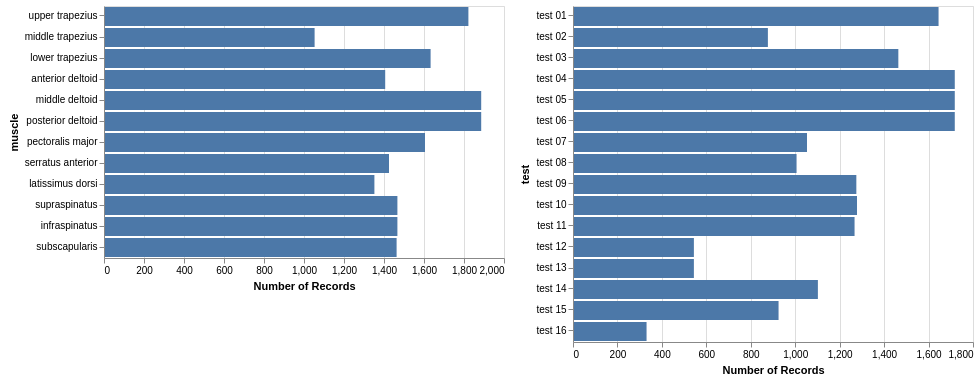

In [7]:
base = alt.Chart(df_tidy).encode(x="count()")
muscle = base.mark_bar().encode(alt.Y("muscle", sort=alt.Sort(MUSCLES)))
test = base.mark_bar().encode(y="test")
muscle | test

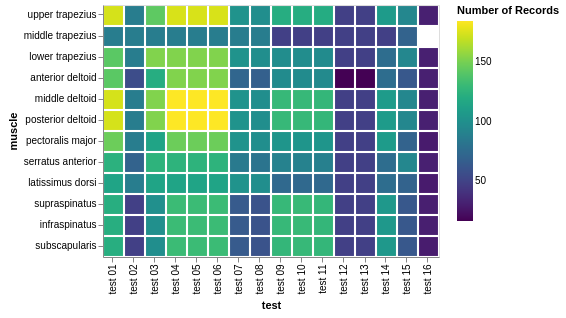

In [8]:
alt.Chart(df_tidy).mark_rect().encode(
    x="test", y=alt.Y("muscle", sort=alt.Sort(MUSCLES)), color="count()"
)

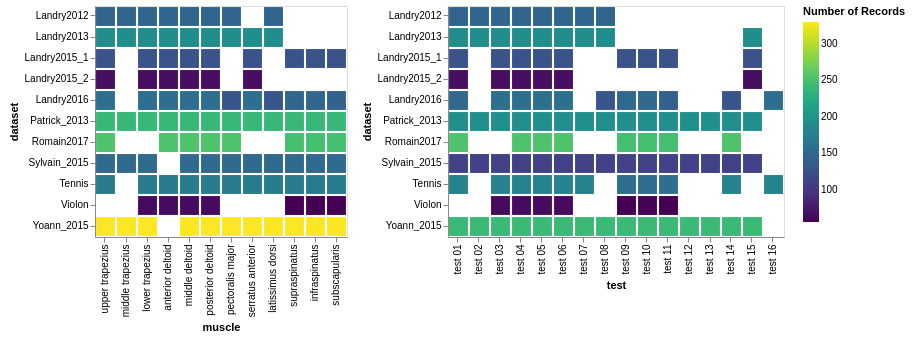

In [9]:
base = alt.Chart(df_tidy).encode(y="dataset", color="count()")
test = base.mark_rect().encode(x="test")
muscle = base.mark_rect().encode(alt.X("muscle", sort=alt.Sort(MUSCLES)))
muscle | test

## NaNs count

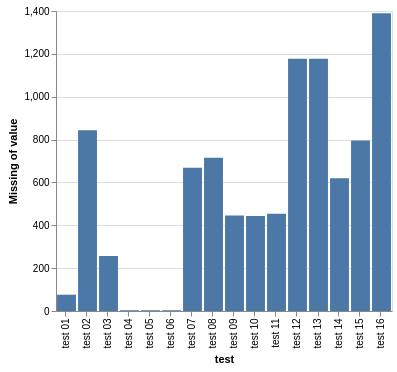

In [10]:
alt.Chart(df_wide.melt(id_vars=["dataset", "participant", "muscle"])).mark_bar().encode(
    x="test", y="missing(value)"
)

## Which test normalizes which muscle

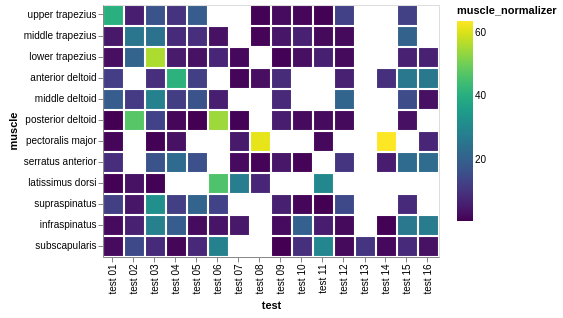

In [11]:
dff = df_tidy.groupby(["test", "muscle"])["mvc"].count().rename("count").to_frame()

max_test = (
    df_tidy.groupby(["participant", "muscle"], as_index=False)
    .apply(lambda x: x["test"][x["mvc"].idxmax()])
    .rename("test")
    .reset_index()
)

dff = dff.merge(
    max_test.groupby(["muscle", "test"]).count().reset_index(), on=["muscle", "test"]
).rename(columns={"participant": "max_test"})


dff["muscle_normalizer"] = dff["max_test"] / dff["count"] * 100

alt.Chart(dff).mark_rect().encode(
    x="test", y=alt.Y("muscle", sort=alt.Sort(MUSCLES)), color="muscle_normalizer"
)

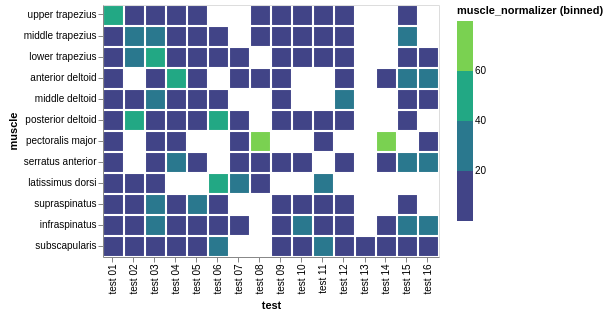

In [12]:
alt.Chart(dff).mark_rect().encode(
    x="test",
    y=alt.Y("muscle", sort=alt.Sort(MUSCLES)),
    color=alt.Color("muscle_normalizer", bin=True),
)


# Part 3: Machine learning pipeline

Since tests number 4, 5 and 6 have few missing data (3) and are good normalizers, we will try to predict the maximum obtained with the 16 tests from these three tests alone.

## Split the data

In [13]:
COLS_TO_KEEP = ['muscle', 'test 04', 'test 05', 'test 06']

In [15]:
X = df_wide[COLS_TO_KEEP]
y = df_wide.select_dtypes(include="float64").max(axis=1)
print(y[:5])
X.head()

0    0.262121
1    0.151734
2    0.300761
3    0.170468
4    0.135626
dtype: float64


test,muscle,test 04,test 05,test 06
0,anterior deltoid,0.262121,0.216671,0.007603
1,latissimus dorsi,0.024144,0.021569,0.151734
2,lower trapezius,0.170296,0.191271,0.070199
3,middle deltoid,0.085861,0.121181,0.035754
4,middle trapezius,0.042650,0.062615,0.046499


We want to make sure that all the data from one participant is in only one set.

In [16]:
from sklearn.model_selection import GroupShuffleSplit

TEST_SIZE = 0.2

train_inds, test_inds = next(
    GroupShuffleSplit(test_size=TEST_SIZE, random_state=RANDOM_SEED).split(
        X, groups=df_wide["participant"]
    )
)
X_train, X_test, y_train, y_test = (
    X.iloc[train_inds],
    X.iloc[test_inds],
    y[train_inds],
    y[test_inds],
)

## Pipeline

In [17]:
X_train.head()

test,muscle,test 04,test 05,test 06
0,anterior deltoid,0.262121,0.216671,0.007603
1,latissimus dorsi,0.024144,0.021569,0.151734
2,lower trapezius,0.170296,0.191271,0.070199
3,middle deltoid,0.085861,0.121181,0.035754
4,middle trapezius,0.042650,0.062615,0.046499


In [76]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder


def get_cat_cols(a):
    return a.select_dtypes(include="object")


def get_num_cols(a):
    return a.select_dtypes(include="float64")


class TestSelector:
    def __init__(self, test=[1, 2, 3]):
        self.test = test

    def transform(self, X, y=None):
        return X.iloc[:, self.test].values

    def fit(self, X, y=None):
        return self


pipeline_categorical = Pipeline(
    [
        ("selector", FunctionTransformer(get_cat_cols, validate=False)),
        ("encoder", OneHotEncoder(sparse=False)),
    ]
)

pipeline_numerical = Pipeline(
    [
        ("selector", FunctionTransformer(get_num_cols, validate=False)),
        ("test_selection", TestSelector(test=[0, 1, 2])),
    ]
)

pipeline_preprocessing = FeatureUnion(
    [("categorical", pipeline_categorical), ("numerical", pipeline_numerical)]
)

In [77]:
pipeline_preprocessing.fit_transform(X_train).shape

(1396, 15)